In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor

import matplotlib.pyplot as plt
import shap

In [4]:
tss = TimeSeriesSplit(n_splits=5)

In [3]:
train_90_df = pd.read_csv('train_90_df.csv')
train_90_df = train_90_df.drop(train_90_df.columns[0], axis=1)

train_90_df_scale = pd.read_csv('train_90_df_scale.csv')
train_90_df_scale = train_90_df_scale.drop(train_90_df_scale.columns[0], axis=1)

test_90_df = pd.read_csv('test_90_df.csv')
test_90_df = test_90_df.drop(test_90_df.columns[0], axis=1)

test_90_df_scale = pd.read_csv('test_90_df_scaled.csv')
test_90_df_scale = test_90_df_scale.drop(test_90_df_scale.columns[0], axis=1)

In [15]:
train_90_df_scale

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30004144.0,0.995412,0.469136,0.030928,0.039216,0.675325,0.630769,0.664234,0.039968,0.0,0.555993,0.240263
1,30004144.0,0.996455,0.320988,0.030928,0.048086,0.675325,0.615385,0.576642,0.037570,0.0,0.555993,0.240263
2,30006983.0,0.992292,0.469136,0.036082,0.058824,0.636364,0.615385,0.452555,0.064748,0.0,0.293120,0.471069
3,30006983.0,0.996676,0.358025,0.046392,0.027544,0.688312,0.707692,0.437956,0.075140,0.0,0.293120,0.471069
4,30023204.0,0.996675,0.493827,0.077320,0.043884,0.610390,0.584615,0.321168,0.215028,0.0,0.985784,0.232249
...,...,...,...,...,...,...,...,...,...,...,...,...
3618,39972274.0,0.994101,0.629630,0.041237,0.027544,0.740260,0.676923,0.605839,0.043165,0.0,0.319432,0.174387
3619,39972274.0,0.997857,0.592593,0.030928,0.020542,0.740260,0.707692,0.635036,0.031175,0.0,0.319432,0.174387
3620,39985110.0,0.993253,0.740741,0.262887,0.044351,0.714286,0.553846,0.591241,0.057554,0.0,0.808567,0.300529
3621,39985110.0,0.994098,0.728395,0.283505,0.044818,0.714286,0.553846,0.605839,0.059153,0.0,0.808567,0.300529


In [16]:
train_90_df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30004144.0,-3.840278,8.0,0.7,114.0,135.0,103.0,13.0,5.1,0.0,26.659722,25.000000
1,30004144.0,-0.240278,6.8,0.7,133.0,135.0,102.0,11.8,4.8,0.0,26.659722,25.000000
2,30006983.0,-14.611667,8.0,0.8,156.0,132.0,102.0,10.1,8.2,0.0,14.055000,49.000000
3,30006983.0,0.521667,7.1,1.0,89.0,136.0,108.0,9.9,9.5,0.0,14.055000,49.000000
4,30023204.0,0.518056,8.2,1.6,124.0,130.0,100.0,8.3,27.0,0.0,47.268056,24.166667
...,...,...,...,...,...,...,...,...,...,...,...,...
3618,39972274.0,-8.366667,9.3,0.9,89.0,140.0,106.0,12.2,5.5,0.0,15.316667,18.150000
3619,39972274.0,4.600000,9.0,0.7,74.0,140.0,108.0,12.6,4.0,0.0,15.316667,18.150000
3620,39985110.0,-11.296111,10.2,5.2,125.0,138.0,98.0,12.0,7.3,0.0,38.770556,31.266667
3621,39985110.0,-8.379444,10.1,5.6,126.0,138.0,98.0,12.2,7.5,0.0,38.770556,31.266667


In [17]:
test_90_df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30005366.0,8.550278,8.8,6.7,41.0,139.0,100.0,9.20,9.4,0.0,20.383611,6.00
1,30034749.0,-131.777778,9.9,0.8,166.0,140.0,100.0,9.65,9.3,0.0,26.522222,20.45
2,30034749.0,-122.194444,8.4,0.8,125.0,143.0,100.0,14.90,5.8,0.0,26.522222,20.45
3,30034749.0,-98.694444,10.0,0.8,141.0,139.0,97.0,9.65,9.3,0.0,26.522222,20.45
4,30034749.0,-88.444444,10.3,0.7,157.0,138.0,98.0,9.65,9.3,0.0,26.522222,20.45
...,...,...,...,...,...,...,...,...,...,...,...,...
1872,39977971.0,1.220833,8.5,2.1,202.0,129.0,96.0,12.40,10.3,0.0,18.287500,4.00
1873,39977971.0,9.537500,8.9,2.2,98.0,132.0,97.0,11.30,9.8,0.0,18.287500,4.00
1874,39982332.0,1.182222,8.4,1.2,119.0,140.0,103.0,11.50,4.7,0.0,20.415556,13.00
1875,39992167.0,2.200000,7.9,0.9,113.0,131.0,100.0,6.80,6.0,0.0,22.000000,84.00


# 90th percentile linear SVM model

## A quick grid search on training scaled 90p data

In [4]:
train_90_df = pd.read_csv('train_90_df.csv')
train_90_df = train_90_df.drop(train_90_df.columns[0], axis=1)

train_90_df_scale = pd.read_csv('train_90_df_scale.csv')
train_90_df_scale = train_90_df_scale.drop(train_90_df_scale.columns[0], axis=1)

test_90_df = pd.read_csv('test_90_df.csv')
test_90_df = test_90_df.drop(test_90_df.columns[0], axis=1)

test_90_df_scale = pd.read_csv('test_90_df_scaled.csv')
test_90_df_scale = test_90_df_scale.drop(test_90_df_scale.columns[0], axis=1)

In [51]:
y_test = test_90_df_scale['vent_duration']
X_test = test_90_df_scale.loc[:, ~test_90_df_scale.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


y_train = train_90_df_scale['vent_duration']
X_train = train_90_df_scale.loc[:, ~train_90_df_scale.columns.isin(['stay_id','icu_intime', 'vent_duration'])]



penalty_lst = ['l1', 'l2','elasticnet']
alpha_lst = sorted([0.0009, 0.001, 0.002], reverse=False)
max_iter_lst = [900, 1000, 1100]
epsilon_lst = sorted([i/1000 for i in range(1,1100,100)], reverse=False)
l1_ratio_lst = sorted([i/100 for i in range(1,100,50)], reverse=False)

param_grid = [{'penalty': penalty_lst,
              'alpha': alpha_lst,
              'max_iter': max_iter_lst,
              'epsilon': epsilon_lst,
               'l1_ratio': l1_ratio_lst}]


model = SGDRegressor(loss='epsilon_insensitive', 
                         fit_intercept=False,  
                         tol=None, shuffle=False, verbose=0,  
                         random_state=None, learning_rate='optimal', eta0=0.001, power_t=0.25, 
                         early_stopping=False, warm_start=False, average=False)


gsSearch = GridSearchCV(estimator = model, param_grid=param_grid, 
                        n_jobs=-1, 
                        cv=tss, 
                        verbose=0, pre_dispatch='2*n_jobs', 
                        error_score=np.nan, return_train_score=False)

gsSearch.fit(X_train, y_train.values.ravel())
y_pred = gsSearch.predict(X_test)

print('best_params = ', gsSearch.best_params_)
print('best_score = ', gsSearch.best_score_)



best_params =  {'alpha': 0.002, 'epsilon': 0.201, 'l1_ratio': 0.01, 'max_iter': 1000, 'penalty': 'l1'}
best_score =  -0.03047333041916651


## using the best param, train scaled data find the RMSE of the unscaled vent_duration and plot the unscaled vent_duration

In [2]:
train_90_df = pd.read_csv('train_90_df.csv')
train_90_df = train_90_df.drop(train_90_df.columns[0], axis=1)

train_90_df_scale = pd.read_csv('train_90_df_scale.csv')
train_90_df_scale = train_90_df_scale.drop(train_90_df_scale.columns[0], axis=1)

test_90_df = pd.read_csv('test_90_df.csv')
test_90_df = test_90_df.drop(test_90_df.columns[0], axis=1)

test_90_df_scale = pd.read_csv('test_90_df_scaled.csv')
test_90_df_scale = test_90_df_scale.drop(test_90_df_scale.columns[0], axis=1)

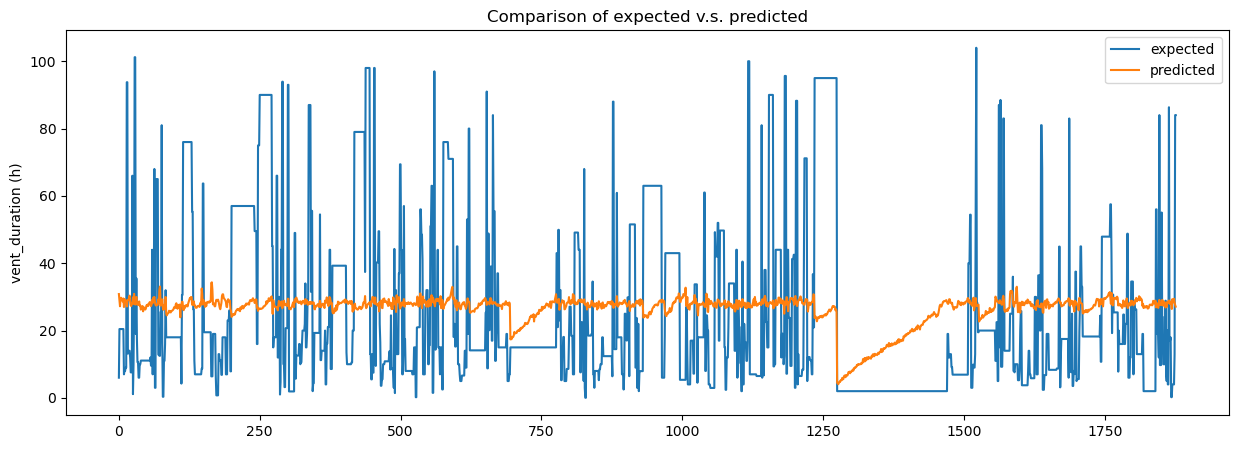

intercept_
[0.]

fit
9 features
charttime : 19.82612593021404
calcium : 3.4635323315729853
creatinine : 10.254140333166267
glucose : 0.0
sodium : 2.2644886749732867
chloride : -5.682044682092629
hemoglobin : -4.760904672541232
wbc : 0.0
vent_start : 0.0

RMSE = 25.250865101509504



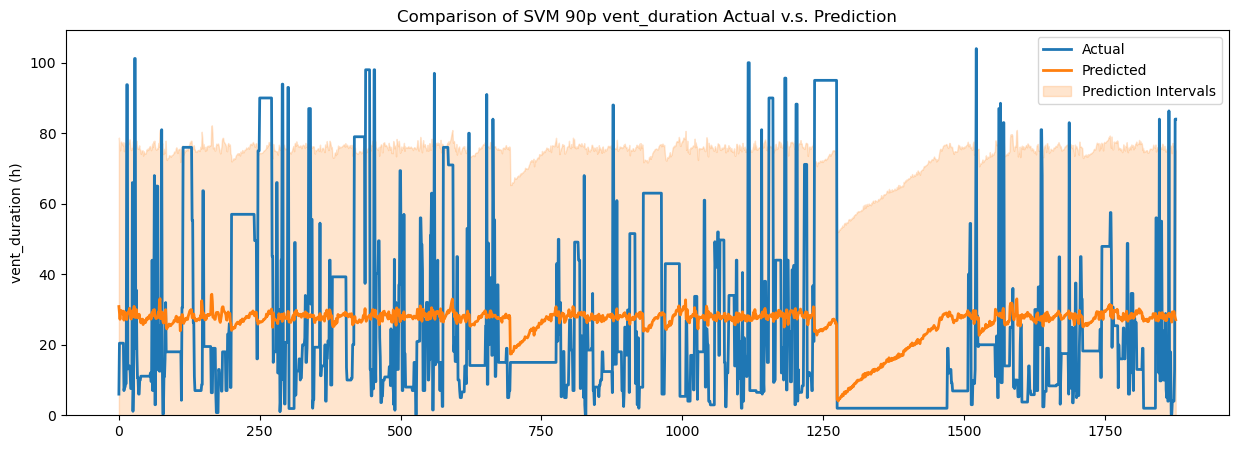

      y_test     y_pred   lower_pi   upper_pi
0       6.00  30.844176 -17.068510  78.756862
1      20.45  28.994716 -18.917970  76.907401
2      20.45  27.218186 -20.694500  75.130872
3      20.45  29.341949 -18.570737  77.254635
4      20.45  29.744512 -18.168174  77.657198
...      ...        ...        ...        ...
1872    4.00  28.859332 -19.053354  76.772018
1873    4.00  29.442130 -18.470556  77.354815
1874   13.00  28.361248 -19.551438  76.273934
1875   84.00  27.605668 -20.307018  75.518354
1876   84.00  27.105192 -20.807494  75.017878

[1877 rows x 4 columns]
      index      y_test     y_pred   lower_pi   upper_pi  index_copy
0       828    0.033333  27.613144 -20.299542  75.525829         828
1       829    0.033333  27.766435 -20.146251  75.679121         829
2       527    0.200000  27.552880 -20.359805  75.465566         527
3       528    0.200000  27.712967 -20.199719  75.625652         528
4      1868    0.216667  28.458388 -19.454298  76.371074        1868
...     .

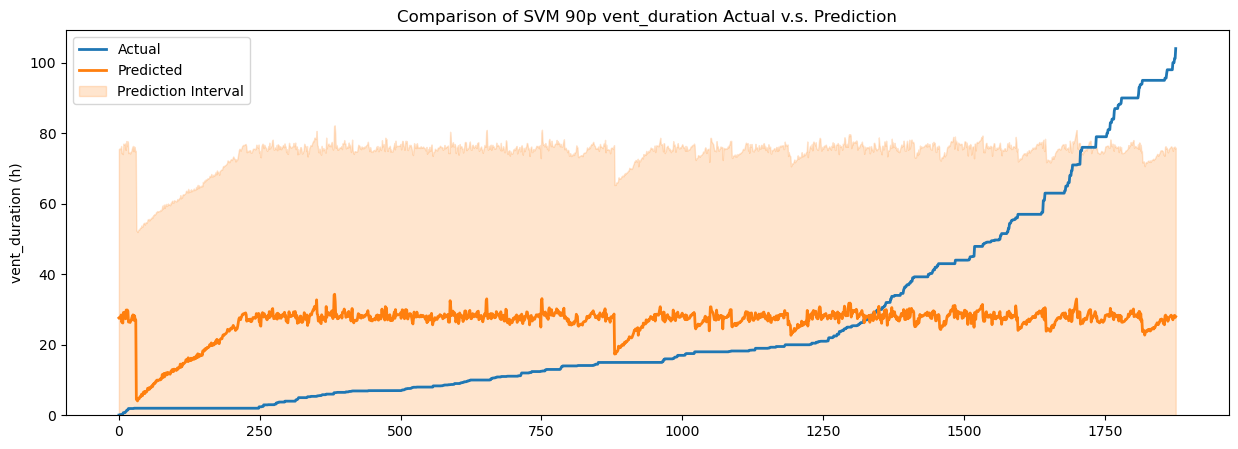

## Shapley Additive Explanations - SHAP value ##



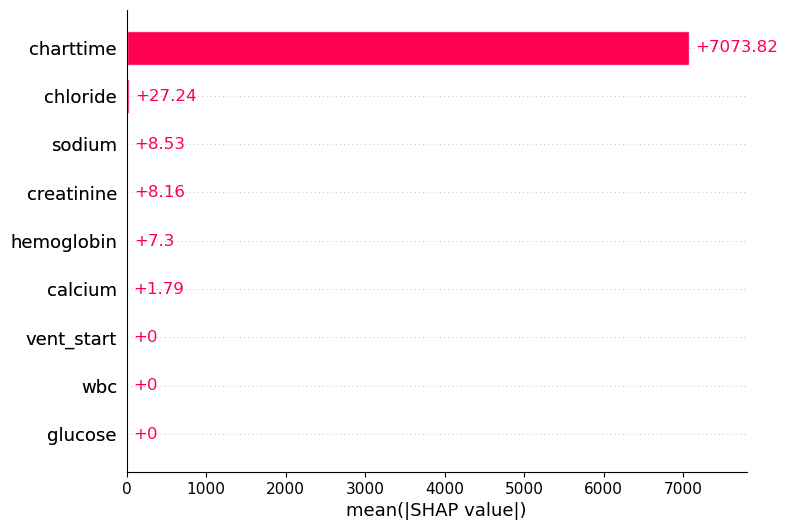

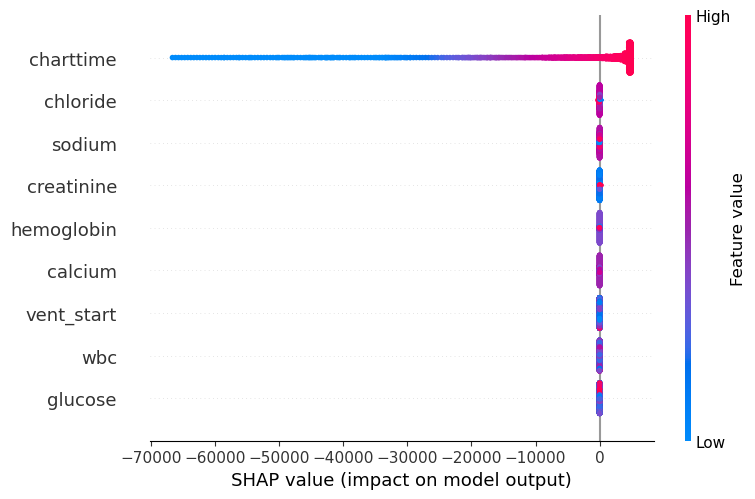

In [53]:
best_params =  {'alpha': 0.002, 'epsilon': 0.201, 'l1_ratio': 0.01, 'max_iter': 1000, 'penalty': 'l1'}

y_test = test_90_df['vent_duration']

#X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration', 'vent_start'])]
X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]

y_train = train_90_df['vent_duration']

#X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration', 'vent_start'])]
X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


model = SGDRegressor(loss='epsilon_insensitive', 
                     penalty=best_params['penalty'], 
                     alpha=best_params['alpha'], 
                     l1_ratio=best_params['l1_ratio'], 
                     max_iter=best_params['max_iter'],
                     epsilon=best_params['epsilon'],
                     fit_intercept=False, tol=None, shuffle=False, 
                     verbose=0, random_state=None, learning_rate='optimal', 
                     eta0=0.001, power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                     n_iter_no_change=5, warm_start=False, average=False)

scaler = MinMaxScaler()
pipe = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

pipe.fit(X_train, y_train)

regressor = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred_inverse = regressor.transformer_.inverse_transform(y_pred.reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(y_test.values.reshape(-1, 1))
y_test_transformed = scaler.transform(y_test.values.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test_transformed)


plt.figure(figsize = (15, 5))
plt.plot(y_test, label = "expected")
plt.plot(y_pred, label = "predicted")
plt.ylabel("vent_duration (h)")
plt.title("Comparison of expected v.s. predicted")
plt.legend()
plt.show()

# Estimate prediction intervals on test set with best estimator
# Here, a non-nested CV approach is used for the sake of computational
# time, but a nested CV approach is preferred.
# See the dedicated example in the gallery for more information.

mapie = MapieRegressor(
    regressor, method="naive", cv=tss, agg_function=None, n_jobs=-1
)
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


print('intercept_')
print(pipe[1].intercept_)
print()

print('fit')
print(str(pipe[1].n_features_in_) + " features")

feature_coef = []
for i in pipe[0].feature_names_in_:
    feature_coef.append(i)
    
coef = []
for i in pipe[1].coef_:
    coef.append(i)

for i in range(len(feature_coef)):
    print(str(feature_coef[i]) + ' : ' + str(coef[i]))

print()

print('RMSE = ' + str(mean_squared_error(y_test, y_pred, squared = False)))

print()

# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test, lw=2, label="Actual", c="C0")
ax.plot(y_test.index, y_pred, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    y_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Intervals",
)
plt.title("Comparison of SVM 90p vent_duration Actual v.s. Prediction")
ax.legend()
plt.show()

# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': y_pred})
y_pis = y_pis.reshape(1877, 2)
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])


# please replace output with a name of your model and the vent_duration percentile. 
output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1) 
print(output)
output['index_copy'] = output.index
output = output.sort_values(by=['y_test', 'index_copy']).reset_index().copy(deep=True)
print(output)

# Plot estimated prediction intervals on test set

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(output['y_test'], lw=2, label="Actual", c="C0")
ax.plot(output.index, output['y_pred'], lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    output.index,
    output['lower_pi'],
    output['upper_pi'],
    color="C1",
    alpha=0.2,
    label="Prediction Interval")
plt.title("Comparison of SVM 90p vent_duration Actual v.s. Prediction")
ax.legend()
plt.show()


import shap
print("## Shapley Additive Explanations - SHAP value ##")
print()
explainer = shap.explainers.Linear(pipe[1], X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=12) # default is max_display=12

print()


shap.summary_plot(shap_values, X_test)





In [9]:
# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': y_pred})
y_pis = y_pis.reshape(1877, 2)
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. e.g."randomforest_90_output"
svm_90_output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1)
print(svm_90_output)
svm_90_output.to_csv('svm_90_output.csv')


      y_test     y_pred   lower_pi   upper_pi
0       6.00  30.844176 -17.068510  78.756862
1      20.45  28.994716 -18.917970  76.907401
2      20.45  27.218186 -20.694500  75.130872
3      20.45  29.341949 -18.570737  77.254635
4      20.45  29.744512 -18.168174  77.657198
...      ...        ...        ...        ...
1872    4.00  28.859332 -19.053354  76.772018
1873    4.00  29.442130 -18.470556  77.354815
1874   13.00  28.361248 -19.551438  76.273934
1875   84.00  27.605668 -20.307018  75.518354
1876   84.00  27.105192 -20.807494  75.017878

[1877 rows x 4 columns]


Increase the number of resamplings
Mean of empty slice
invalid value encountered in divide


intercept_
[0.]

fit
9 features
charttime : 19.82612593021404
calcium : 3.4635323315729853
creatinine : 10.254140333166267
glucose : 0.0
sodium : 2.2644886749732867
chloride : -5.682044682092629
hemoglobin : -4.760904672541232
wbc : 0.0
vent_start : 0.0

RMSE = 25.250865101509504

0        6.00
1       20.45
2       20.45
3       20.45
4       20.45
        ...  
1872     4.00
1873     4.00
1874    13.00
1875    84.00
1876    84.00
Name: vent_duration, Length: 1877, dtype: float64
         y_pred
0     30.844176
1     28.994716
2     27.218186
3     29.341949
4     29.744512
...         ...
1872  28.859332
1873  29.442130
1874  28.361248
1875  27.605668
1876  27.105192

[1877 rows x 1 columns]
      y_test     y_pred   lower_pi   upper_pi
0       6.00  30.844176 -22.523076  76.391697
1      20.45  28.994716 -24.282416  73.469529
2      20.45  27.218186 -24.197920  73.544934
3      20.45  29.341949 -23.946185  73.808322
4      20.45  29.744512 -23.781988  73.843809
...      ...        .

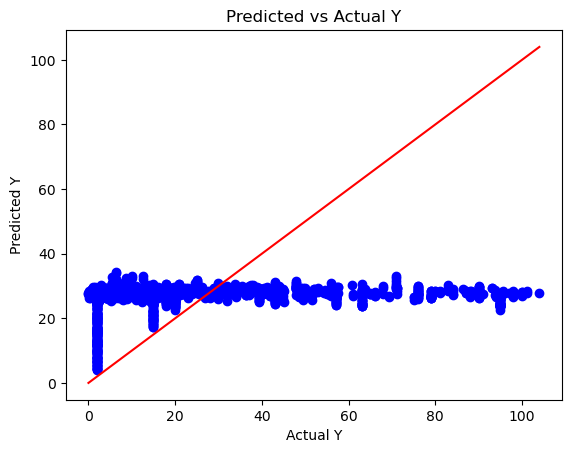

In [50]:
best_params =  {'alpha': 0.002, 'epsilon': 0.201, 'l1_ratio': 0.01, 'max_iter': 1000, 'penalty': 'l1'}

y_test = test_90_df['vent_duration']

#X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration', 'vent_start'])]
X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]

y_train = train_90_df['vent_duration']

#X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration', 'vent_start'])]
X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


model = SGDRegressor(loss='epsilon_insensitive', 
                     penalty=best_params['penalty'], 
                     alpha=best_params['alpha'], 
                     l1_ratio=best_params['l1_ratio'], 
                     max_iter=best_params['max_iter'],
                     epsilon=best_params['epsilon'],
                     fit_intercept=False, tol=None, shuffle=False, 
                     verbose=0, random_state=None, learning_rate='optimal', 
                     eta0=0.001, power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                     n_iter_no_change=5, warm_start=False, average=False)

scaler = MinMaxScaler()
pipe = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

pipe.fit(X_train, y_train)

regressor = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred_inverse = regressor.transformer_.inverse_transform(y_pred.reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(y_test.values.reshape(-1, 1))
y_test_transformed = scaler.transform(y_test.values.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test_transformed)


# Estimate prediction intervals on test set with best estimator
# Here, a non-nested CV approach is used for the sake of computational
# time, but a nested CV approach is preferred.
# See the dedicated example in the gallery for more information.

mapie = MapieRegressor(
    regressor, method="plus", cv=tss, agg_function=None, n_jobs=-1
)
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


print('intercept_')
print(pipe[1].intercept_)
print()

print('fit')
print(str(pipe[1].n_features_in_) + " features")

feature_coef = []
for i in pipe[0].feature_names_in_:
    feature_coef.append(i)
    
coef = []
for i in pipe[1].coef_:
    coef.append(i)

for i in range(len(feature_coef)):
    print(str(feature_coef[i]) + ' : ' + str(coef[i]))

print()

print('RMSE = ' + str(mean_squared_error(y_test, y_pred, squared = False)))

print()

# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
print(y_test)
y_pred_df = pd.DataFrame({'y_pred': y_pred})
print(y_pred_df)
y_pis = y_pis.reshape(1877, 2)


y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. 
output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1) 
print(output)
output['index_copy'] = output.index
output = output.sort_values(by=['y_test', 'index_copy']).copy(deep=True)
print(output)
      
# Create a scatter plot of predicted y vs actual y
plt.scatter(output['y_test'], output['y_pred'], color='blue')

# Add a diagonal line for reference
plt.plot([min(output['y_test']), max(output['y_test'])], [min(output['y_test']), max(output['y_test'])], color='red')

# Add labels for the axes
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')

# Add a title for the plot
plt.title('Predicted vs Actual Y')

# Display the plot
plt.show()

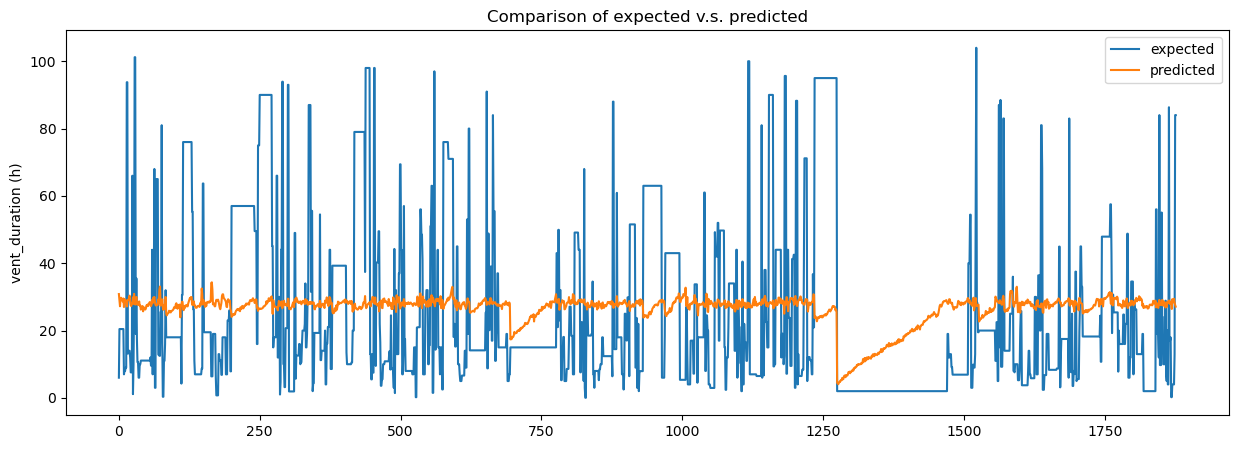

intercept_
[0.]

fit
9 features
charttime : 19.82612593021404
calcium : 3.4635323315729853
creatinine : 10.254140333166267
glucose : 0.0
sodium : 2.2644886749732867
chloride : -5.682044682092629
hemoglobin : -4.760904672541232
wbc : 0.0
vent_start : 0.0

RMSE = 25.250865101509504

0        6.00
1       20.45
2       20.45
3       20.45
4       20.45
        ...  
1872     4.00
1873     4.00
1874    13.00
1875    84.00
1876    84.00
Name: vent_duration, Length: 1877, dtype: float64
[30.84417596 28.99471555 27.21818612 ... 28.36124787 27.60566779
 27.10519216]
      y_test     y_pred   lower_pi   upper_pi
0       6.00  30.844176 -17.068510  78.756862
1      20.45  28.994716 -18.917970  76.907401
2      20.45  27.218186 -20.694500  75.130872
3      20.45  29.341949 -18.570737  77.254635
4      20.45  29.744512 -18.168174  77.657198
...      ...        ...        ...        ...
1872    4.00  28.859332 -19.053354  76.772018
1873    4.00  29.442130 -18.470556  77.354815
1874   13.00  28.3612

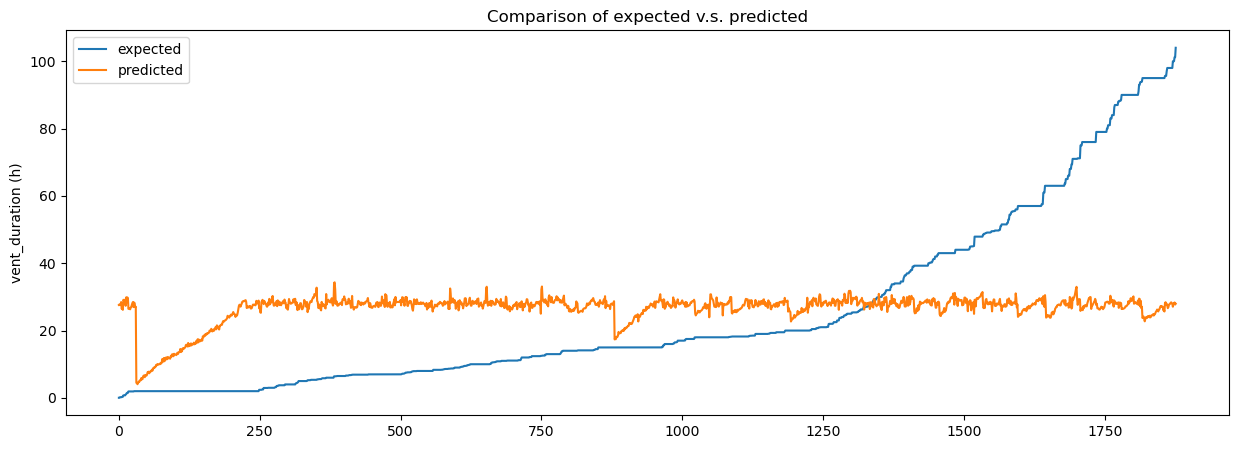

<Figure size 1500x1500 with 0 Axes>

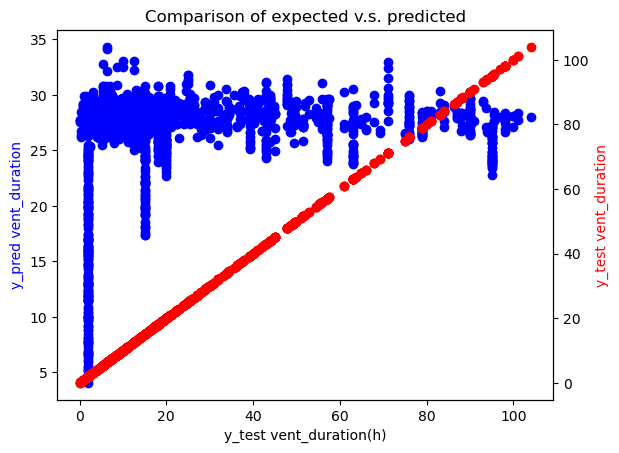

In [132]:
best_params =  {'alpha': 0.002, 'epsilon': 0.201, 'l1_ratio': 0.01, 'max_iter': 1000, 'penalty': 'l1'}

y_test = test_90_df['vent_duration']

#X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration', 'vent_start'])]
X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]

y_train = train_90_df['vent_duration']

#X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration', 'vent_start'])]
X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


model = SGDRegressor(loss='epsilon_insensitive', 
                     penalty=best_params['penalty'], 
                     alpha=best_params['alpha'], 
                     l1_ratio=best_params['l1_ratio'], 
                     max_iter=best_params['max_iter'],
                     epsilon=best_params['epsilon'],
                     fit_intercept=False, tol=None, shuffle=False, 
                     verbose=0, random_state=None, learning_rate='optimal', 
                     eta0=0.001, power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                     n_iter_no_change=5, warm_start=False, average=False)

scaler = MinMaxScaler()
pipe = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

pipe.fit(X_train, y_train)

regressor = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred_inverse = regressor.transformer_.inverse_transform(y_pred.reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(y_test.values.reshape(-1, 1))
y_test_transformed = scaler.transform(y_test.values.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test_transformed)


plt.figure(figsize = (15, 5))
plt.plot(y_test, label = "expected")
plt.plot(y_pred, label = "predicted")
plt.ylabel("vent_duration (h)")
plt.title("Comparison of expected v.s. predicted")
plt.legend()
plt.show()

# Estimate prediction intervals on test set with best estimator
# Here, a non-nested CV approach is used for the sake of computational
# time, but a nested CV approach is preferred.
# See the dedicated example in the gallery for more information.

mapie = MapieRegressor(
    regressor, method="naive", cv=tss, agg_function=None, n_jobs=-1
)
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


print('intercept_')
print(pipe[1].intercept_)
print()

print('fit')
print(str(pipe[1].n_features_in_) + " features")

feature_coef = []
for i in pipe[0].feature_names_in_:
    feature_coef.append(i)
    
coef = []
for i in pipe[1].coef_:
    coef.append(i)

for i in range(len(feature_coef)):
    print(str(feature_coef[i]) + ' : ' + str(coef[i]))

print()

print('RMSE = ' + str(mean_squared_error(y_test, y_pred, squared = False)))

print()


print(y_test)
print(y_pred)
# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': y_pred})
y_pis = y_pis.reshape(1877, 2)
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])


# please replace output with a name of your model and the vent_duration percentile. 
output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1) 
print(output)
output['index_copy'] = output.index
output = output.sort_values(by=['y_test', 'index_copy']).reset_index().copy(deep=True)
print(output)

# Plot estimated prediction intervals on test set
plt.figure(figsize = (15, 5))
plt.plot(output['y_test'], label = "expected")
plt.plot(output['y_pred'], label = "predicted")
plt.ylabel("vent_duration (h)")
plt.title("Comparison of expected v.s. predicted")
plt.legend()
plt.show()

# Plot estimated prediction intervals on test set
plt.figure(figsize = (15, 15))
fig, ax1 = plt.subplots()
ax1.scatter(output['y_test'], output['y_pred'], color='blue')
ax1.set_ylabel('y_pred vent_duration', color='blue')
ax2 = ax1.twinx()

# Plot the second set of data on the right y-axis
ax2.scatter(output['y_test'], output['y_test'], color='red')
ax2.set_ylabel('y_test vent_duration', color='red')

ax1.set_title("Comparison of expected v.s. predicted")
ax1.set_xlabel('y_test vent_duration(h)')

plt.show()


## A quick grid search on training unscaled 90p data (sanity check)

In [4]:
train_90_df = pd.read_csv('train_90_df.csv')
train_90_df = train_90_df.drop(train_90_df.columns[0], axis=1)

train_90_df_scale = pd.read_csv('train_90_df_scale.csv')
train_90_df_scale = train_90_df_scale.drop(train_90_df_scale.columns[0], axis=1)

test_90_df = pd.read_csv('test_90_df.csv')
test_90_df = test_90_df.drop(test_90_df.columns[0], axis=1)

test_90_df_scale = pd.read_csv('test_90_df_scaled.csv')
test_90_df_scale = test_90_df_scale.drop(test_90_df_scale.columns[0], axis=1)

In [5]:
y_test = test_90_df['vent_duration']
X_test = test_90_df.loc[:, ~train_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


y_train = train_90_df['vent_duration']
X_train = train_90_df.loc[:, ~train_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]



penalty_lst = ['l1', 'l2','elasticnet']
alpha_lst = sorted([00.075, 0.1, 0.125], reverse=False)
max_iter_lst = [450, 500, 550]
epsilon_lst = sorted([2.50, 3, 3.5, 4, 4.5], reverse=False)
l1_ratio_lst = sorted([0.3,0.5,0.7], reverse=False)

param_grid = [{'penalty': penalty_lst,
              'alpha': alpha_lst,
              'max_iter': max_iter_lst,
              'epsilon': epsilon_lst,
               'l1_ratio': l1_ratio_lst}]


model = SGDRegressor(loss='epsilon_insensitive', 
                         fit_intercept=False,  
                         tol=None, shuffle=False, verbose=0,  
                         random_state=None, learning_rate='optimal', eta0=0.001, power_t=0.25, 
                         early_stopping=False, warm_start=False, average=False)


gsSearch = GridSearchCV(estimator = model, param_grid=param_grid, 
                        n_jobs=-1, 
                        cv=tss, 
                        verbose=0, pre_dispatch='2*n_jobs', 
                        error_score=np.nan, return_train_score=False)

gsSearch.fit(X_train, y_train.values.ravel())
y_pred = gsSearch.predict(X_test)

print('best_params = ', gsSearch.best_params_)
print('best_score = ', gsSearch.best_score_)



NameError: name 'tss' is not defined

## using the best param, train unscaled data find the RMSE of the vent_duration and plot the  vent_duration

intercept_
[0.]

fit
8 features
charttime : 0.0
calcium : 0.0
creatinine : 0.0
glucose : 0.03589899819741601
sodium : 0.1699191966265527
chloride : -0.011911305543853223
hemoglobin : 0.0
wbc : 0.0

RMSE = 26.64284838517765


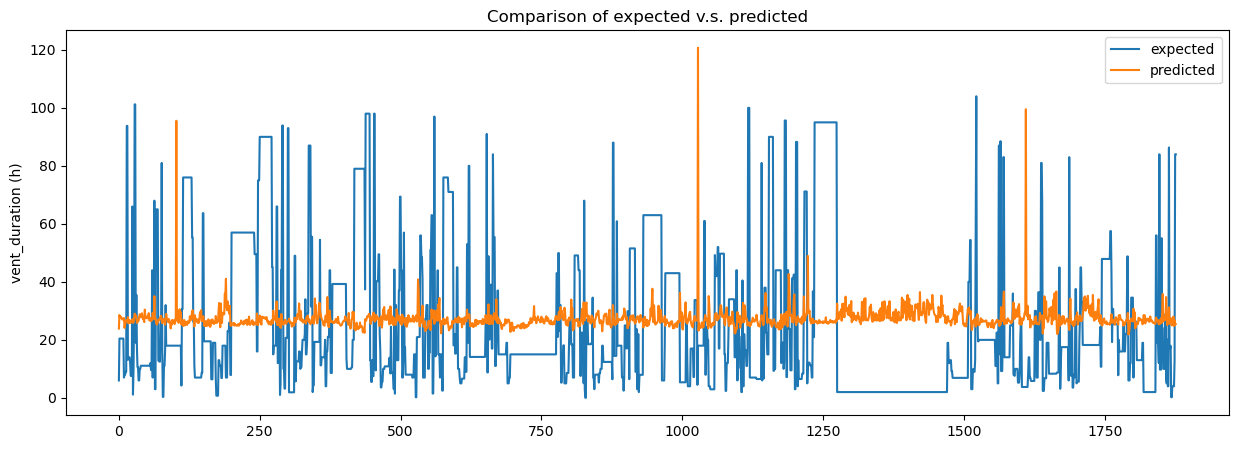

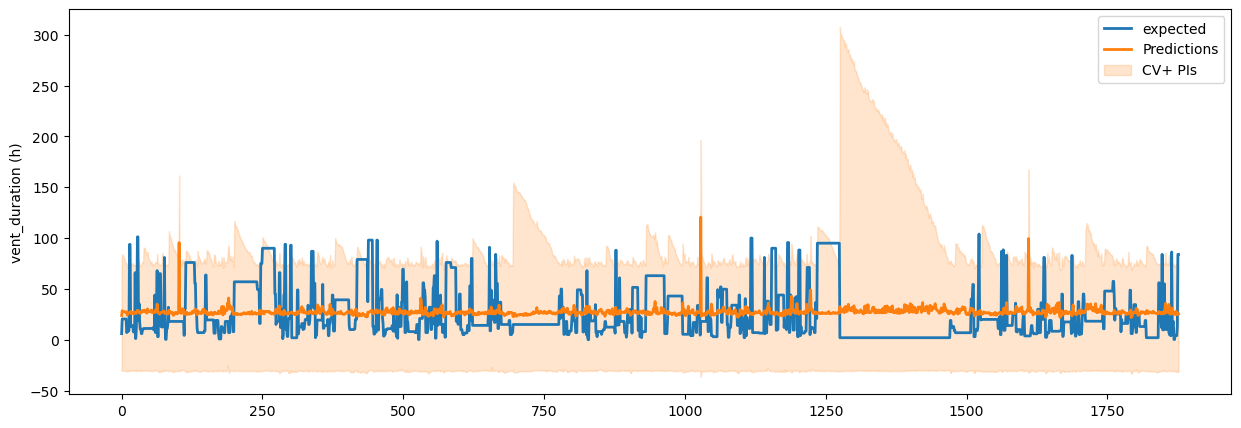

In [13]:
best_params =  {'alpha': 0.125, 'epsilon': 4.5, 'l1_ratio': 0.5, 'max_iter': 500, 'penalty': 'elasticnet'}

y_test = test_90_df['vent_duration']

X_test = test_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]

y_train = train_90_df['vent_duration']

X_train = train_90_df.loc[:, ~test_90_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


model = SGDRegressor(loss='epsilon_insensitive', 
                     penalty=best_params['penalty'], 
                     alpha=best_params['alpha'], 
                     l1_ratio=best_params['l1_ratio'], 
                     max_iter=best_params['max_iter'],
                     epsilon=best_params['epsilon'],
                     fit_intercept=False, tol=None, shuffle=False, 
                     verbose=0, random_state=None, learning_rate='optimal', 
                     eta0=0.001, power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                     n_iter_no_change=5, warm_start=False, average=False)

pipe = Pipeline([('model', model)])

pipe.fit(X_train, y_train)


y_pred = pipe.predict(X_test)



print('intercept_')
print(pipe[0].intercept_)
print()

print('fit')
print(str(pipe[0].n_features_in_) + " features")

feature_coef = []
for i in pipe[0].feature_names_in_:
    feature_coef.append(i)
    
coef = []
for i in pipe[0].coef_:
    coef.append(i)

for i in range(len(feature_coef)):
    print(str(feature_coef[i]) + ' : ' + str(coef[i]))

print()

print('RMSE = ' + str(mean_squared_error(y_test, y_pred, squared = False)))

plt.figure(figsize = (15, 5))
plt.plot(y_test, label = "expected")
plt.plot(y_pred, label = "predicted")
plt.ylabel("vent_duration (h)")
plt.title("Comparison of expected v.s. predicted")
plt.legend()
plt.show()

# Estimate prediction intervals on test set with best estimator
# Here, a non-nested CV approach is used for the sake of computational
# time, but a nested CV approach is preferred.
# See the dedicated example in the gallery for more information.
alpha = 0.1
mapie = MapieRegressor(
    pipe, method="minmax", agg_function="median", n_jobs=-1
)
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=alpha)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test, lw=2, label="expected", c="C0")
ax.plot(y_test.index, y_pred, lw=2, c="C1", label="Predictions")
ax.fill_between(
    y_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="CV+ PIs",
)
ax.legend()
plt.show()


# 100th percentile linear SVM model

## A quick grid search on training scaled 100p data

In [10]:
train_100_df = pd.read_csv('train_100_df.csv')
train_100_df = train_100_df.drop(train_100_df.columns[0], axis=1)

train_100_df_scale = pd.read_csv('train_100_df_scale.csv')
train_100_df_scale = train_100_df_scale.drop(train_100_df_scale.columns[0], axis=1)

test_100_df = pd.read_csv('test_100_df.csv')
test_100_df = test_100_df.drop(test_100_df.columns[0], axis=1)

test_100_df_scale = pd.read_csv('test_100_df_scaled.csv')
test_100_df_scale = test_100_df_scale.drop(test_100_df_scale.columns[0], axis=1)

In [134]:
train_100_df_scale

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30004144.0,0.995412,0.4625,0.030612,0.028571,0.509804,0.450549,0.631944,0.039968,0.0,0.555758,0.041353
1,30004144.0,0.996455,0.3125,0.030612,0.035034,0.509804,0.439560,0.548611,0.037570,0.0,0.555758,0.041353
2,30006983.0,0.992292,0.4625,0.035714,0.042857,0.480392,0.439560,0.430556,0.064748,0.0,0.292996,0.081078
3,30006983.0,0.996675,0.3500,0.045918,0.020068,0.519608,0.505495,0.402778,0.076739,0.0,0.292996,0.081078
4,30023204.0,0.996674,0.4875,0.076531,0.031973,0.460784,0.417582,0.305556,0.215028,0.0,0.985367,0.039974
...,...,...,...,...,...,...,...,...,...,...,...,...
4394,39972274.0,0.997857,0.5875,0.030612,0.014966,0.558824,0.505495,0.604167,0.031175,0.0,0.319297,0.030015
4395,39977971.0,0.993421,0.5875,0.091837,0.022449,0.500000,0.395604,0.493056,0.047962,0.0,0.381228,0.006593
4396,39977971.0,0.995039,0.5125,0.051020,0.031633,0.539216,0.439560,0.402778,0.076739,0.0,0.381228,0.006593
4397,39977971.0,0.996878,0.5250,0.102041,0.058503,0.450980,0.373626,0.590278,0.081535,0.0,0.381228,0.006593


In [135]:
train_100_df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30004144.0,-3.840278,8.0,0.7,114.0,135.0,103.0,13.0,5.1,0.0,26.659722,25.000000
1,30004144.0,-0.240278,6.8,0.7,133.0,135.0,102.0,11.8,4.8,0.0,26.659722,25.000000
2,30006983.0,-14.611667,8.0,0.8,156.0,132.0,102.0,10.1,8.2,0.0,14.055000,49.000000
3,30006983.0,0.521667,7.1,1.0,89.0,136.0,108.0,9.7,9.7,0.0,14.055000,49.000000
4,30023204.0,0.518056,8.2,1.6,124.0,130.0,100.0,8.3,27.0,0.0,47.268056,24.166667
...,...,...,...,...,...,...,...,...,...,...,...,...
4394,39972274.0,4.600000,9.0,0.7,74.0,140.0,108.0,12.6,4.0,0.0,15.316667,18.150000
4395,39977971.0,-10.712500,9.0,1.9,96.0,134.0,98.0,11.0,6.1,0.0,18.287500,4.000000
4396,39977971.0,-5.129167,8.4,1.1,123.0,138.0,102.0,9.7,9.7,0.0,18.287500,4.000000
4397,39977971.0,1.220833,8.5,2.1,202.0,129.0,96.0,12.4,10.3,0.0,18.287500,4.000000


In [136]:
test_100_df_scale

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30005366.0,0.999053,0.567901,0.384615,0.006849,0.474576,0.492063,0.364286,0.096674,0.0,0.425104,0.010287
1,30034749.0,0.960173,0.703704,0.035503,0.220890,0.491525,0.492063,0.421429,0.090437,0.0,0.553126,0.035917
2,30034749.0,0.962828,0.518519,0.035503,0.154110,0.542373,0.492063,0.771429,0.059252,0.0,0.553126,0.035917
3,30034749.0,0.969339,0.716049,0.035503,0.178082,0.474576,0.444444,0.421429,0.090437,0.0,0.553126,0.035917
4,30034749.0,0.972179,0.753086,0.029586,0.205479,0.457627,0.460317,0.421429,0.090437,0.0,0.553126,0.035917
...,...,...,...,...,...,...,...,...,...,...,...,...
1740,39985110.0,0.998528,0.765432,0.390533,0.191781,0.474576,0.460317,0.607143,0.106029,0.0,0.808567,0.055102
1741,39986206.0,0.996825,0.419753,0.319527,0.143836,0.474576,0.539683,0.421429,0.198545,0.0,0.470800,0.393402
1742,39986206.0,0.998603,0.407407,0.343195,0.109589,0.474576,0.539683,0.450000,0.189189,0.0,0.470800,0.393402
1743,39992167.0,0.997294,0.456790,0.041420,0.130137,0.338983,0.492063,0.192857,0.061331,0.0,0.458814,0.148634


In [137]:
test_100_df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30005366.0,8.550278,8.8,6.7,41.0,139.0,100.0,9.2,9.4,0.0,20.383611,6.000000
1,30034749.0,-131.777778,9.9,0.8,166.0,140.0,100.0,10.0,8.8,0.0,26.522222,20.450000
2,30034749.0,-122.194444,8.4,0.8,127.0,143.0,100.0,14.9,5.8,0.0,26.522222,20.450000
3,30034749.0,-98.694444,10.0,0.8,141.0,139.0,97.0,10.0,8.8,0.0,26.522222,20.450000
4,30034749.0,-88.444444,10.3,0.7,157.0,138.0,98.0,10.0,8.8,0.0,26.522222,20.450000
...,...,...,...,...,...,...,...,...,...,...,...,...
1740,39985110.0,6.653889,10.4,6.8,149.0,139.0,98.0,12.6,10.3,0.0,38.770556,31.266667
1741,39986206.0,0.508056,7.6,5.6,121.0,139.0,103.0,10.0,19.2,0.0,22.574722,222.000000
1742,39986206.0,6.924722,7.5,6.0,101.0,139.0,103.0,10.4,18.3,0.0,22.574722,222.000000
1743,39992167.0,2.200000,7.9,0.9,113.0,131.0,100.0,6.8,6.0,0.0,22.000000,84.000000


In [164]:
y_test = test_100_df['vent_duration']
X_test = test_100_df.loc[:, ~train_100_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]


y_train = train_100_df['vent_duration']
X_train = train_100_df.loc[:, ~train_100_df_scale.columns.isin(['stay_id','icu_intime', 'vent_duration'])]



penalty_lst = ['elasticnet']
alpha_lst = sorted([0.006, 0.007, 0.008], reverse=False)
max_iter_lst = [450, 500, 550]
epsilon_lst = sorted([0.03,0.05,0.08], reverse=False)
l1_ratio_lst = sorted([0.03,0.04,0.05], reverse=False)

param_grid = [{'penalty': penalty_lst,
              'alpha': alpha_lst,
              'max_iter': max_iter_lst,
              'epsilon': epsilon_lst,
               'l1_ratio': l1_ratio_lst}]


model = SGDRegressor(loss='epsilon_insensitive', 
                         fit_intercept=True,  
                         tol=None, shuffle=False, verbose=0,  
                         random_state=None, learning_rate='optimal', eta0=0.001, power_t=0.25, 
                         early_stopping=False, warm_start=False, average=False)


gsSearch = GridSearchCV(estimator = model, param_grid=param_grid, 
                        n_jobs=12, 
                        cv=tss, 
                        verbose=0, pre_dispatch='2*n_jobs', 
                        error_score=np.nan, return_train_score=False)

gsSearch.fit(X_train, y_train.values.ravel())
y_pred = gsSearch.predict(X_test)

print('best_params = ', gsSearch.best_params_)
print('best_score = ', gsSearch.best_score_)



best_params =  {'alpha': 0.007, 'epsilon': 0.05, 'l1_ratio': 0.03, 'max_iter': 450, 'penalty': 'elasticnet'}
best_score =  -0.052222095221542066


## using the best param, train scaled data find the RMSE of the unscaled vent_duration and plot the unscaled vent_duration

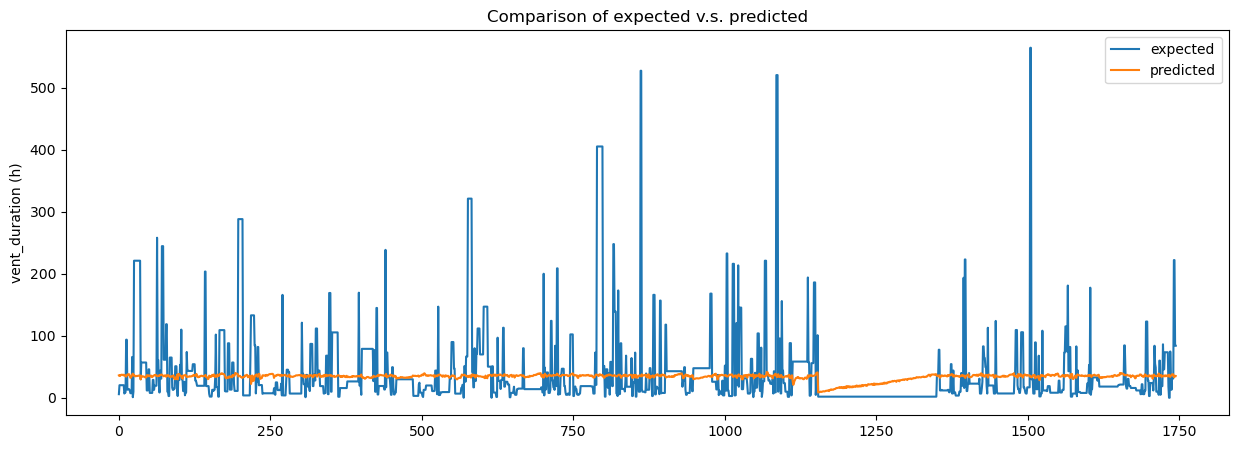

intercept_
[0.]

fit
9 features
charttime : 9.86134027803706
calcium : 3.981724134234281
creatinine : 1.2980106357771908
glucose : 0.23481107765115106
sodium : 4.555843321811562
chloride : 3.8635057071480436
hemoglobin : 2.6116190503168726
wbc : 0.5210716612332018
vent_start : 2.7251135959616177

RMSE = 65.32772402806188



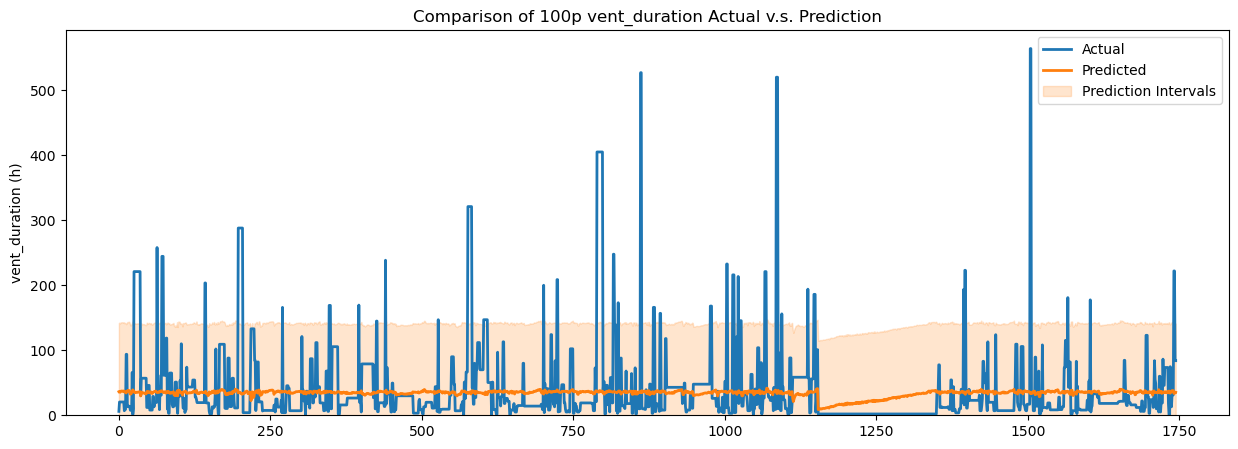

          y_test     y_pred   lower_pi    upper_pi
0       6.000000  36.305742 -69.500335  142.111818
1      20.450000  36.773217 -69.032859  142.579294
2      20.450000  35.348141 -70.457935  141.154218
3      20.450000  36.708587 -69.097489  142.514663
4      20.450000  37.327946 -68.478131  143.134022
...          ...        ...        ...         ...
1740   31.266667  37.948077 -67.858000  143.754153
1741  222.000000  33.600351 -72.205726  139.406427
1742  222.000000  33.657809 -72.148267  139.463885
1743   84.000000  35.607063 -70.199013  141.413139
1744   84.000000  35.329702 -70.476374  141.135779

[1745 rows x 4 columns]
      index      y_test     y_pred   lower_pi    upper_pi  index_copy
0       615    0.200000  35.096287 -70.709790  140.902363         615
1      1733    0.216667  37.323192 -68.482884  143.129269        1733
2      1734    0.216667  34.462781 -71.343295  140.268858        1734
3       569    0.266667  36.907954 -68.898122  142.714030         569
4       645  

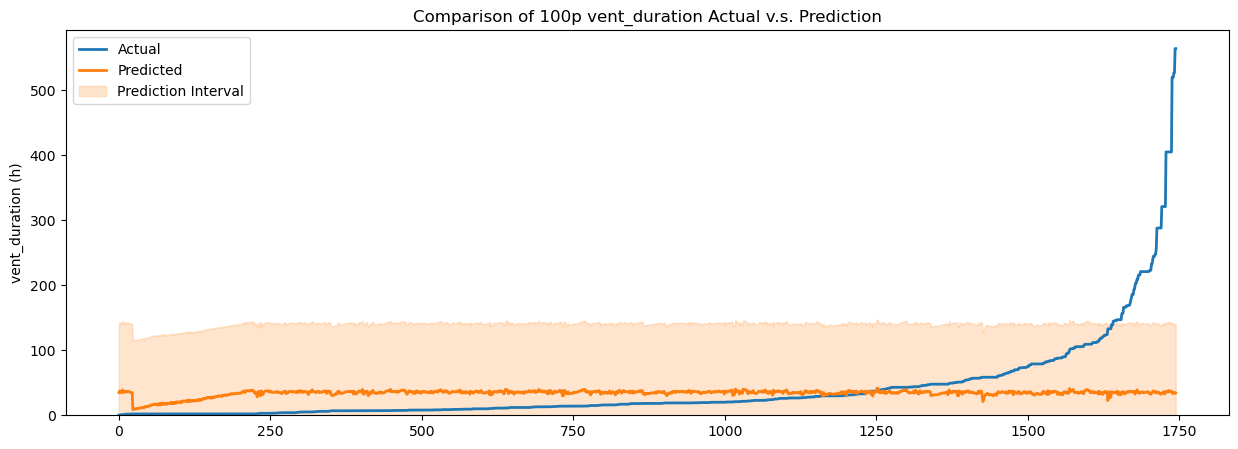

In [11]:
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieRegressor


best_params =  {'alpha': 0.007, 'epsilon': 0.05, 'l1_ratio': 0.03, 'max_iter': 450, 'penalty': 'elasticnet'}

y_test = test_100_df['vent_duration']

X_test = test_100_df.loc[:, ~test_100_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]

y_train = train_100_df['vent_duration']

X_train = train_100_df.loc[:, ~test_100_df.columns.isin(['stay_id','icu_intime', 'vent_duration'])]

model = SGDRegressor(loss='epsilon_insensitive', 
                     penalty=best_params['penalty'], 
                     alpha=best_params['alpha'], 
                     l1_ratio=best_params['l1_ratio'], 
                     max_iter=best_params['max_iter'],
                     epsilon=best_params['epsilon'],
                     fit_intercept=False, tol=None, shuffle=False, 
                     verbose=0, random_state=None, learning_rate='optimal', 
                     eta0=0.001, power_t=0.25, early_stopping=False, validation_fraction=0.1, 
                     n_iter_no_change=5, warm_start=False, average=False)

scaler = MinMaxScaler()
pipe = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

pipe.fit(X_train, y_train)

regressor = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred_inverse = regressor.transformer_.inverse_transform(y_pred.reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(y_test.values.reshape(-1, 1))
y_test_transformed = scaler.transform(y_test.values.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test_transformed)


plt.figure(figsize = (15, 5))
plt.plot(y_test, label = "expected")
plt.plot(y_pred, label = "predicted")
plt.ylabel("vent_duration (h)")
plt.title("Comparison of expected v.s. predicted")
plt.legend()
plt.show()

# Estimate prediction intervals on test set with best estimator
# Here, a non-nested CV approach is used for the sake of computational
# time, but a nested CV approach is preferred.
# See the dedicated example in the gallery for more information.

mapie = MapieRegressor(
    regressor, method="naive", cv=tss, agg_function=None, n_jobs=-1
)
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


print('intercept_')
print(pipe[1].intercept_)
print()

print('fit')
print(str(pipe[1].n_features_in_) + " features")

feature_coef = []
for i in pipe[0].feature_names_in_:
    feature_coef.append(i)
    
coef = []
for i in pipe[1].coef_:
    coef.append(i)

for i in range(len(feature_coef)):
    print(str(feature_coef[i]) + ' : ' + str(coef[i]))

print()

print('RMSE = ' + str(mean_squared_error(y_test, y_pred, squared = False)))

print()

# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test, lw=2, label="Actual", c="C0")
ax.plot(y_test.index, y_pred, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    y_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Intervals",
)
plt.title("Comparison of 100p vent_duration Actual v.s. Prediction")
ax.legend()
plt.show()



# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': y_pred})
y_pis = np.reshape(y_pis, (y_pis.shape[0],2)) 
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. 
output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1) 
print(output)
output['index_copy'] = output.index
output = output.sort_values(by=['y_test', 'index_copy']).reset_index().copy(deep=True)
print(output)




# Plot estimated prediction intervals on test set

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(output['y_test'], lw=2, label="Actual", c="C0")
ax.plot(output.index, output['y_pred'], lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    output.index,
    output['lower_pi'],
    output['upper_pi'],
    color="C1",
    alpha=0.2,
    label="Prediction Interval")
plt.title("Comparison of 100p vent_duration Actual v.s. Prediction")
ax.legend()
plt.show()

In [12]:
# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': y_pred})
y_pis = np.reshape(y_pis, (y_pis.shape[0],2)) 
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. e.g."randomforest_90_output"
svm_100_output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1)
print(svm_100_output)
svm_100_output.to_csv('svm_100_output.csv')

          y_test     y_pred   lower_pi    upper_pi
0       6.000000  36.305742 -69.500335  142.111818
1      20.450000  36.773217 -69.032859  142.579294
2      20.450000  35.348141 -70.457935  141.154218
3      20.450000  36.708587 -69.097489  142.514663
4      20.450000  37.327946 -68.478131  143.134022
...          ...        ...        ...         ...
1740   31.266667  37.948077 -67.858000  143.754153
1741  222.000000  33.600351 -72.205726  139.406427
1742  222.000000  33.657809 -72.148267  139.463885
1743   84.000000  35.607063 -70.199013  141.413139
1744   84.000000  35.329702 -70.476374  141.135779

[1745 rows x 4 columns]
